In [46]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    a=2
    b=1
    r1=1
    r2=2
    r3=-1
    r4=4*a*b/(a**2+b**2)
    beta=1
    
    f_u1 = (
            v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
            -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
            v2_t + beta*u2_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
            -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

k1=1.5
k2=1
l1=1.5
l2=-1
nf1=0
nf2=0
ng1=0
ng2=0
k=complex(k1,-k2)
kk=k.conjugate()
l=complex(l1,-l2)
ll=l.conjugate()
nf=complex(nf1,-nf2)
nff=nf.conjugate()
ng=complex(ng1,-ng2)
ngg=ng.conjugate()


def init_cond_u1(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result=q1.real
    
    
    #result=( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
     #      )
    return result
    
def init_cond_u2(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result=q2.real
    #result=( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
      #     )
    return result

def init_cond_v1(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result=-q1.imag
    
    #result=-( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result

def init_cond_v2(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    Q1=f/phi1+g/phi2
    Q2=1j*(f/phi1-g/phi2)
    q1=((Q1+Q2)/(a+b)+(Q1-Q2)/(a-b))/2
    q2=((Q1+Q2)/(a+b)-(Q1-Q2)/(a-b))/2
    
    result= -q2.imag
    
    #result= ( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)

D:\anaconda\python.exe
D:\anaconda\python.exe


In [47]:
model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=3000, display_every=10)

Compiling model...
Building feed-forward neural network...
'build' took 0.095490 s



C:\Users\86183\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 8.823364 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [5.77e-05, 5.57e-05, 5.36e-06, 2.20e-05, 3.09e-02, 1.15e-03, 5.19e-03, 1.76e-04, 1.93e-02, 5.35e-04, 8.58e-03, 5.91e-06, 2.08e-02, 6.95e-02, 3.49e-02, 5.74e-02]    [5.77e-05, 5.57e-05, 5.36e-06, 2.20e-05, 3.09e-02, 1.15e-03, 5.19e-03, 1.76e-04, 1.93e-02, 5.35e-04, 8.58e-03, 5.91e-06, 2.08e-02, 6.95e-02, 3.49e-02, 5.74e-02]    []  
10        [1.15e-04, 5.75e-05, 5.99e-05, 3.58e-05, 2.77e-03, 3.44e-05, 9.38e-04, 6.00e-05, 3.27e-03, 1.28e-04, 7.05e-04, 2.80e-04, 2.01e-02, 6.36e-02, 3.08e-02, 5.15e-02]    [1.15e-04, 5.75e-05, 5.99e-05, 3.58e-05, 2.77e-03, 3.44e-05, 

230       [4.05e-03, 4.71e-03, 5.19e-03, 3.68e-03, 5.07e-05, 6.43e-06, 2.94e-05, 2.24e-05, 4.45e-05, 3.98e-05, 4.76e-05, 1.30e-04, 1.03e-02, 1.07e-02, 1.05e-02, 1.06e-02]    [4.05e-03, 4.71e-03, 5.19e-03, 3.68e-03, 5.07e-05, 6.43e-06, 2.94e-05, 2.24e-05, 4.45e-05, 3.98e-05, 4.76e-05, 1.30e-04, 1.03e-02, 1.07e-02, 1.05e-02, 1.06e-02]    []  
240       [3.56e-03, 4.60e-03, 5.05e-03, 3.66e-03, 5.57e-05, 1.25e-05, 2.70e-05, 7.48e-06, 2.42e-05, 3.67e-05, 1.10e-05, 1.21e-04, 9.98e-03, 9.87e-03, 9.55e-03, 1.02e-02]    [3.56e-03, 4.60e-03, 5.05e-03, 3.66e-03, 5.57e-05, 1.25e-05, 2.70e-05, 7.48e-06, 2.42e-05, 3.67e-05, 1.10e-05, 1.21e-04, 9.98e-03, 9.87e-03, 9.55e-03, 1.02e-02]    []  
250       [3.58e-03, 4.78e-03, 5.23e-03, 3.77e-03, 4.00e-05, 1.20e-05, 1.96e-05, 9.02e-06, 2.31e-05, 2.87e-05, 1.32e-06, 1.26e-04, 9.53e-03, 8.60e-03, 8.80e-03, 9.28e-03]    [3.58e-03, 4.78e-03, 5.23e-03, 3.77e-03, 4.00e-05, 1.20e-05, 1.96e-05, 9.02e-06, 2.31e-05, 2.87e-05, 1.32e-06, 1.26e-04, 9.53e-03, 8.60e-03,

470       [2.25e-03, 3.83e-03, 2.86e-03, 3.57e-03, 6.70e-05, 1.31e-05, 1.07e-04, 3.39e-05, 6.59e-05, 2.93e-05, 9.30e-05, 5.87e-05, 3.66e-03, 4.14e-03, 3.12e-03, 4.29e-03]    [2.25e-03, 3.83e-03, 2.86e-03, 3.57e-03, 6.70e-05, 1.31e-05, 1.07e-04, 3.39e-05, 6.59e-05, 2.93e-05, 9.30e-05, 5.87e-05, 3.66e-03, 4.14e-03, 3.12e-03, 4.29e-03]    []  
480       [2.22e-03, 3.59e-03, 2.68e-03, 3.31e-03, 1.67e-04, 1.67e-05, 3.23e-05, 1.58e-05, 1.11e-05, 2.68e-05, 1.80e-04, 1.46e-04, 3.14e-03, 4.21e-03, 3.48e-03, 4.22e-03]    [2.22e-03, 3.59e-03, 2.68e-03, 3.31e-03, 1.67e-04, 1.67e-05, 3.23e-05, 1.58e-05, 1.11e-05, 2.68e-05, 1.80e-04, 1.46e-04, 3.14e-03, 4.21e-03, 3.48e-03, 4.22e-03]    []  
490       [2.23e-03, 3.87e-03, 2.71e-03, 3.09e-03, 3.77e-05, 5.30e-06, 1.29e-04, 1.17e-05, 6.46e-06, 2.80e-05, 3.29e-05, 5.39e-05, 2.90e-03, 4.05e-03, 3.18e-03, 3.83e-03]    [2.23e-03, 3.87e-03, 2.71e-03, 3.09e-03, 3.77e-05, 5.30e-06, 1.29e-04, 1.17e-05, 6.46e-06, 2.80e-05, 3.29e-05, 5.39e-05, 2.90e-03, 4.05e-03,

710       [2.19e-03, 2.53e-03, 2.45e-03, 2.50e-03, 4.32e-05, 1.26e-05, 4.01e-05, 1.65e-06, 6.29e-06, 1.05e-04, 5.51e-06, 5.07e-05, 1.65e-03, 2.71e-03, 1.76e-03, 2.42e-03]    [2.19e-03, 2.53e-03, 2.45e-03, 2.50e-03, 4.32e-05, 1.26e-05, 4.01e-05, 1.65e-06, 6.29e-06, 1.05e-04, 5.51e-06, 5.07e-05, 1.65e-03, 2.71e-03, 1.76e-03, 2.42e-03]    []  
720       [2.18e-03, 2.52e-03, 2.44e-03, 2.45e-03, 4.37e-05, 1.26e-05, 3.96e-05, 1.21e-06, 6.48e-06, 1.11e-04, 5.67e-06, 4.92e-05, 1.60e-03, 2.66e-03, 1.72e-03, 2.35e-03]    [2.18e-03, 2.52e-03, 2.44e-03, 2.45e-03, 4.37e-05, 1.26e-05, 3.96e-05, 1.21e-06, 6.48e-06, 1.11e-04, 5.67e-06, 4.92e-05, 1.60e-03, 2.66e-03, 1.72e-03, 2.35e-03]    []  
730       [2.17e-03, 2.53e-03, 2.43e-03, 2.41e-03, 4.91e-05, 1.27e-05, 3.98e-05, 9.86e-07, 7.79e-06, 1.14e-04, 8.39e-06, 4.71e-05, 1.55e-03, 2.61e-03, 1.66e-03, 2.30e-03]    [2.17e-03, 2.53e-03, 2.43e-03, 2.41e-03, 4.91e-05, 1.27e-05, 3.98e-05, 9.86e-07, 7.79e-06, 1.14e-04, 8.39e-06, 4.71e-05, 1.55e-03, 2.61e-03,

950       [1.96e-03, 2.11e-03, 2.15e-03, 2.07e-03, 4.69e-05, 6.38e-06, 3.26e-05, 3.22e-06, 3.96e-06, 1.14e-04, 7.83e-06, 3.34e-05, 1.02e-03, 1.73e-03, 1.08e-03, 1.54e-03]    [1.96e-03, 2.11e-03, 2.15e-03, 2.07e-03, 4.69e-05, 6.38e-06, 3.26e-05, 3.22e-06, 3.96e-06, 1.14e-04, 7.83e-06, 3.34e-05, 1.02e-03, 1.73e-03, 1.08e-03, 1.54e-03]    []  
960       [1.94e-03, 1.91e-03, 2.11e-03, 2.48e-03, 2.70e-04, 4.72e-05, 3.41e-04, 7.63e-05, 7.97e-05, 1.34e-04, 7.75e-05, 7.36e-05, 1.68e-03, 2.33e-03, 1.33e-03, 2.01e-03]    [1.94e-03, 1.91e-03, 2.11e-03, 2.48e-03, 2.70e-04, 4.72e-05, 3.41e-04, 7.63e-05, 7.97e-05, 1.34e-04, 7.75e-05, 7.36e-05, 1.68e-03, 2.33e-03, 1.33e-03, 2.01e-03]    []  
970       [1.88e-03, 2.01e-03, 2.21e-03, 2.07e-03, 4.24e-05, 8.27e-06, 4.92e-05, 7.63e-06, 9.78e-06, 9.68e-05, 2.82e-05, 3.75e-05, 1.09e-03, 1.70e-03, 9.97e-04, 1.61e-03]    [1.88e-03, 2.01e-03, 2.21e-03, 2.07e-03, 4.24e-05, 8.27e-06, 4.92e-05, 7.63e-06, 9.78e-06, 9.68e-05, 2.82e-05, 3.75e-05, 1.09e-03, 1.70e-03,

1190      [1.79e-03, 1.90e-03, 1.91e-03, 1.87e-03, 5.64e-05, 4.38e-06, 2.98e-05, 9.70e-06, 8.75e-06, 6.13e-05, 5.78e-06, 2.85e-05, 7.30e-04, 1.21e-03, 8.37e-04, 1.11e-03]    [1.79e-03, 1.90e-03, 1.91e-03, 1.87e-03, 5.64e-05, 4.38e-06, 2.98e-05, 9.70e-06, 8.75e-06, 6.13e-05, 5.78e-06, 2.85e-05, 7.30e-04, 1.21e-03, 8.37e-04, 1.11e-03]    []  
1200      [1.79e-03, 1.79e-03, 1.79e-03, 1.85e-03, 3.90e-04, 6.43e-05, 4.14e-04, 3.56e-05, 2.54e-04, 1.28e-04, 1.77e-04, 8.31e-05, 7.63e-04, 1.39e-03, 1.03e-03, 1.78e-03]    [1.79e-03, 1.79e-03, 1.79e-03, 1.85e-03, 3.90e-04, 6.43e-05, 4.14e-04, 3.56e-05, 2.54e-04, 1.28e-04, 1.77e-04, 8.31e-05, 7.63e-04, 1.39e-03, 1.03e-03, 1.78e-03]    []  
1210      [1.84e-03, 1.78e-03, 1.90e-03, 1.93e-03, 5.88e-05, 5.10e-06, 2.27e-05, 1.18e-05, 4.41e-06, 4.65e-05, 2.14e-05, 6.81e-05, 7.48e-04, 1.21e-03, 7.70e-04, 1.37e-03]    [1.84e-03, 1.78e-03, 1.90e-03, 1.93e-03, 5.88e-05, 5.10e-06, 2.27e-05, 1.18e-05, 4.41e-06, 4.65e-05, 2.14e-05, 6.81e-05, 7.48e-04, 1.21e-03,

1430      [1.62e-03, 1.76e-03, 1.76e-03, 1.65e-03, 4.44e-05, 1.37e-05, 2.06e-05, 6.81e-06, 6.20e-06, 3.92e-05, 9.55e-06, 1.87e-05, 5.75e-04, 9.45e-04, 6.25e-04, 8.03e-04]    [1.62e-03, 1.76e-03, 1.76e-03, 1.65e-03, 4.44e-05, 1.37e-05, 2.06e-05, 6.81e-06, 6.20e-06, 3.92e-05, 9.55e-06, 1.87e-05, 5.75e-04, 9.45e-04, 6.25e-04, 8.03e-04]    []  
1440      [1.64e-03, 1.75e-03, 1.83e-03, 1.76e-03, 6.68e-05, 1.51e-05, 5.21e-05, 7.31e-06, 1.14e-05, 4.09e-05, 5.05e-05, 1.60e-05, 5.85e-04, 9.18e-04, 5.59e-04, 8.26e-04]    [1.64e-03, 1.75e-03, 1.83e-03, 1.76e-03, 6.68e-05, 1.51e-05, 5.21e-05, 7.31e-06, 1.14e-05, 4.09e-05, 5.05e-05, 1.60e-05, 5.85e-04, 9.18e-04, 5.59e-04, 8.26e-04]    []  
1450      [1.63e-03, 1.86e-03, 1.67e-03, 1.54e-03, 1.72e-04, 4.27e-05, 5.40e-05, 2.29e-05, 1.72e-04, 3.73e-05, 9.58e-06, 1.62e-04, 6.58e-04, 1.50e-03, 9.27e-04, 1.04e-03]    [1.63e-03, 1.86e-03, 1.67e-03, 1.54e-03, 1.72e-04, 4.27e-05, 5.40e-05, 2.29e-05, 1.72e-04, 3.73e-05, 9.58e-06, 1.62e-04, 6.58e-04, 1.50e-03,

1670      [1.46e-03, 1.53e-03, 1.60e-03, 1.42e-03, 1.13e-04, 3.15e-05, 7.08e-05, 1.08e-05, 7.62e-05, 7.92e-05, 6.72e-06, 5.53e-05, 4.57e-04, 7.62e-04, 5.96e-04, 6.02e-04]    [1.46e-03, 1.53e-03, 1.60e-03, 1.42e-03, 1.13e-04, 3.15e-05, 7.08e-05, 1.08e-05, 7.62e-05, 7.92e-05, 6.72e-06, 5.53e-05, 4.57e-04, 7.62e-04, 5.96e-04, 6.02e-04]    []  
1680      [1.70e-03, 1.76e-03, 1.88e-03, 1.58e-03, 3.71e-04, 1.20e-04, 6.18e-04, 1.85e-05, 2.08e-04, 7.90e-05, 2.49e-04, 1.73e-04, 6.08e-04, 1.50e-03, 5.31e-04, 9.02e-04]    [1.70e-03, 1.76e-03, 1.88e-03, 1.58e-03, 3.71e-04, 1.20e-04, 6.18e-04, 1.85e-05, 2.08e-04, 7.90e-05, 2.49e-04, 1.73e-04, 6.08e-04, 1.50e-03, 5.31e-04, 9.02e-04]    []  
1690      [1.65e-03, 1.48e-03, 1.82e-03, 1.43e-03, 1.51e-04, 4.76e-05, 5.45e-05, 1.50e-05, 1.41e-04, 8.18e-05, 2.57e-05, 3.08e-05, 5.12e-04, 9.69e-04, 1.05e-03, 7.83e-04]    [1.65e-03, 1.48e-03, 1.82e-03, 1.43e-03, 1.51e-04, 4.76e-05, 5.45e-05, 1.50e-05, 1.41e-04, 8.18e-05, 2.57e-05, 3.08e-05, 5.12e-04, 9.69e-04,

1910      [1.37e-03, 1.30e-03, 1.45e-03, 1.33e-03, 2.66e-05, 1.07e-05, 2.49e-05, 1.20e-05, 1.83e-05, 5.83e-05, 2.24e-05, 3.18e-05, 4.58e-04, 6.45e-04, 4.89e-04, 5.16e-04]    [1.37e-03, 1.30e-03, 1.45e-03, 1.33e-03, 2.66e-05, 1.07e-05, 2.49e-05, 1.20e-05, 1.83e-05, 5.83e-05, 2.24e-05, 3.18e-05, 4.58e-04, 6.45e-04, 4.89e-04, 5.16e-04]    []  
1920      [1.37e-03, 1.35e-03, 1.45e-03, 1.30e-03, 1.89e-05, 8.99e-06, 2.44e-05, 6.49e-06, 4.22e-06, 4.91e-05, 9.05e-06, 2.45e-05, 3.70e-04, 6.52e-04, 4.89e-04, 4.95e-04]    [1.37e-03, 1.35e-03, 1.45e-03, 1.30e-03, 1.89e-05, 8.99e-06, 2.44e-05, 6.49e-06, 4.22e-06, 4.91e-05, 9.05e-06, 2.45e-05, 3.70e-04, 6.52e-04, 4.89e-04, 4.95e-04]    []  
1930      [1.35e-03, 1.30e-03, 1.44e-03, 1.32e-03, 1.78e-05, 9.77e-06, 1.93e-05, 6.72e-06, 4.14e-06, 5.05e-05, 4.30e-06, 2.15e-05, 4.31e-04, 6.42e-04, 4.45e-04, 4.87e-04]    [1.35e-03, 1.30e-03, 1.44e-03, 1.32e-03, 1.78e-05, 9.77e-06, 1.93e-05, 6.72e-06, 4.14e-06, 5.05e-05, 4.30e-06, 2.15e-05, 4.31e-04, 6.42e-04,

2150      [1.37e-03, 1.43e-03, 1.42e-03, 1.28e-03, 2.96e-05, 7.22e-05, 3.88e-05, 3.15e-05, 3.10e-05, 3.90e-05, 3.52e-05, 2.48e-05, 5.33e-04, 6.59e-04, 5.48e-04, 6.03e-04]    [1.37e-03, 1.43e-03, 1.42e-03, 1.28e-03, 2.96e-05, 7.22e-05, 3.88e-05, 3.15e-05, 3.10e-05, 3.90e-05, 3.52e-05, 2.48e-05, 5.33e-04, 6.59e-04, 5.48e-04, 6.03e-04]    []  
2160      [1.26e-03, 1.21e-03, 1.36e-03, 1.29e-03, 2.29e-05, 6.08e-06, 5.55e-05, 8.23e-06, 2.31e-05, 4.12e-05, 1.37e-04, 4.10e-05, 4.63e-04, 6.08e-04, 4.10e-04, 4.92e-04]    [1.26e-03, 1.21e-03, 1.36e-03, 1.29e-03, 2.29e-05, 6.08e-06, 5.55e-05, 8.23e-06, 2.31e-05, 4.12e-05, 1.37e-04, 4.10e-05, 4.63e-04, 6.08e-04, 4.10e-04, 4.92e-04]    []  
2170      [1.27e-03, 1.21e-03, 1.28e-03, 1.22e-03, 3.77e-05, 6.90e-06, 2.01e-05, 1.36e-05, 6.41e-05, 4.37e-05, 1.60e-05, 3.32e-05, 3.68e-04, 5.84e-04, 4.34e-04, 4.80e-04]    [1.27e-03, 1.21e-03, 1.28e-03, 1.22e-03, 3.77e-05, 6.90e-06, 2.01e-05, 1.36e-05, 6.41e-05, 4.37e-05, 1.60e-05, 3.32e-05, 3.68e-04, 5.84e-04,

2390      [1.15e-03, 1.17e-03, 1.23e-03, 1.18e-03, 4.98e-05, 2.18e-05, 3.31e-05, 3.06e-05, 3.46e-05, 6.82e-05, 8.50e-05, 4.41e-05, 4.67e-04, 5.82e-04, 4.03e-04, 5.04e-04]    [1.15e-03, 1.17e-03, 1.23e-03, 1.18e-03, 4.98e-05, 2.18e-05, 3.31e-05, 3.06e-05, 3.46e-05, 6.82e-05, 8.50e-05, 4.41e-05, 4.67e-04, 5.82e-04, 4.03e-04, 5.04e-04]    []  
2400      [1.16e-03, 1.09e-03, 1.21e-03, 1.16e-03, 4.26e-05, 6.26e-06, 2.66e-05, 1.07e-05, 1.83e-05, 3.48e-05, 4.45e-06, 2.84e-05, 2.94e-04, 5.23e-04, 4.93e-04, 4.82e-04]    [1.16e-03, 1.09e-03, 1.21e-03, 1.16e-03, 4.26e-05, 6.26e-06, 2.66e-05, 1.07e-05, 1.83e-05, 3.48e-05, 4.45e-06, 2.84e-05, 2.94e-04, 5.23e-04, 4.93e-04, 4.82e-04]    []  
2410      [1.13e-03, 1.08e-03, 1.16e-03, 1.17e-03, 1.26e-05, 8.06e-06, 1.73e-05, 8.16e-06, 6.23e-06, 2.02e-05, 6.58e-06, 2.21e-05, 3.14e-04, 5.23e-04, 3.67e-04, 4.18e-04]    [1.13e-03, 1.08e-03, 1.16e-03, 1.17e-03, 1.26e-05, 8.06e-06, 1.73e-05, 8.16e-06, 6.23e-06, 2.02e-05, 6.58e-06, 2.21e-05, 3.14e-04, 5.23e-04,

2630      [1.29e-03, 1.16e-03, 1.24e-03, 1.19e-03, 1.09e-03, 2.16e-04, 8.41e-04, 1.33e-04, 6.83e-05, 5.57e-04, 1.70e-04, 1.01e-03, 4.36e-04, 9.22e-04, 4.41e-04, 7.21e-04]    [1.29e-03, 1.16e-03, 1.24e-03, 1.19e-03, 1.09e-03, 2.16e-04, 8.41e-04, 1.33e-04, 6.83e-05, 5.57e-04, 1.70e-04, 1.01e-03, 4.36e-04, 9.22e-04, 4.41e-04, 7.21e-04]    []  
2640      [1.07e-03, 1.10e-03, 1.26e-03, 1.26e-03, 2.62e-05, 2.14e-05, 1.18e-04, 1.16e-05, 2.70e-05, 3.17e-05, 2.23e-04, 2.84e-05, 4.14e-04, 4.84e-04, 4.54e-04, 4.32e-04]    [1.07e-03, 1.10e-03, 1.26e-03, 1.26e-03, 2.62e-05, 2.14e-05, 1.18e-04, 1.16e-05, 2.70e-05, 3.17e-05, 2.23e-04, 2.84e-05, 4.14e-04, 4.84e-04, 4.54e-04, 4.32e-04]    []  
2650      [1.04e-03, 9.70e-04, 1.05e-03, 1.13e-03, 1.80e-05, 9.98e-06, 4.23e-05, 1.04e-05, 2.42e-05, 4.33e-05, 3.64e-05, 5.28e-05, 5.10e-04, 5.11e-04, 3.41e-04, 4.32e-04]    [1.04e-03, 9.70e-04, 1.05e-03, 1.13e-03, 1.80e-05, 9.98e-06, 4.23e-05, 1.04e-05, 2.42e-05, 4.33e-05, 3.64e-05, 5.28e-05, 5.10e-04, 5.11e-04,

2870      [9.07e-04, 9.14e-04, 9.04e-04, 1.02e-03, 1.83e-04, 4.50e-05, 1.76e-04, 3.46e-05, 4.15e-05, 1.39e-04, 1.08e-04, 1.10e-04, 2.06e-04, 4.47e-04, 3.38e-04, 3.49e-04]    [9.07e-04, 9.14e-04, 9.04e-04, 1.02e-03, 1.83e-04, 4.50e-05, 1.76e-04, 3.46e-05, 4.15e-05, 1.39e-04, 1.08e-04, 1.10e-04, 2.06e-04, 4.47e-04, 3.38e-04, 3.49e-04]    []  
2880      [1.10e-03, 1.13e-03, 1.16e-03, 1.09e-03, 8.54e-05, 1.74e-04, 1.53e-04, 9.33e-05, 1.20e-04, 6.44e-05, 1.07e-03, 3.20e-05, 4.33e-04, 1.37e-03, 5.43e-04, 6.13e-04]    [1.10e-03, 1.13e-03, 1.16e-03, 1.09e-03, 8.54e-05, 1.74e-04, 1.53e-04, 9.33e-05, 1.20e-04, 6.44e-05, 1.07e-03, 3.20e-05, 4.33e-04, 1.37e-03, 5.43e-04, 6.13e-04]    []  
2890      [9.11e-04, 1.13e-03, 9.99e-04, 1.11e-03, 1.54e-04, 1.22e-04, 1.74e-04, 1.21e-04, 1.19e-04, 1.16e-04, 1.16e-04, 8.81e-05, 2.33e-04, 6.16e-04, 3.30e-04, 4.09e-04]    [9.11e-04, 1.13e-03, 9.99e-04, 1.11e-03, 1.54e-04, 1.22e-04, 1.74e-04, 1.21e-04, 1.19e-04, 1.16e-04, 1.16e-04, 8.81e-05, 2.33e-04, 6.16e-04,

(<deepxde.model.LossHistory at 0x17f921c3eb0>,
 <deepxde.model.TrainState at 0x17f921c3e50>)

Compiling model...
'compile' took 6.584327 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
3000      [9.70e-04, 1.08e-03, 1.11e-03, 1.04e-03, 2.38e-05, 1.07e-04, 7.72e-05, 2.30e-05, 2.65e-05, 1.61e-04, 2.53e-04, 4.44e-05, 4.75e-04, 9.24e-04, 3.52e-04, 3.36e-04]    [9.70e-04, 1.08e-03, 1.11e-03, 1.04e-03, 2.38e-05, 1.07e-04, 7.72e-05, 2.30e-05, 2.65e-05, 1.61e-04, 2.53e-04, 4.44e-05, 4.75e-04, 9.24e-04, 3.52e-04, 3.36e-04]    []  
4000      [4.04e-04, 4.06e-04, 4.15e-04, 4.12e-04, 3.87e-06, 3.15e-06, 3.17e-06, 6.91e-06, 1.20e-06, 4.79e-06, 1.44e-06, 8.15e-06, 5.71e-05, 1.72e-04, 9.23e-05, 1.26e-04]                                                                        

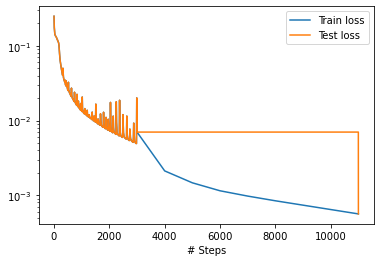

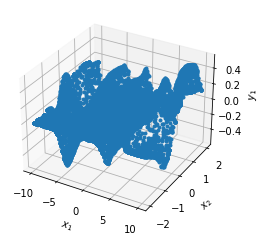

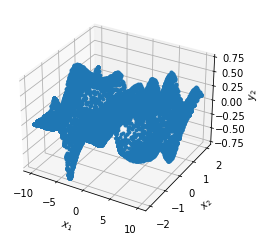

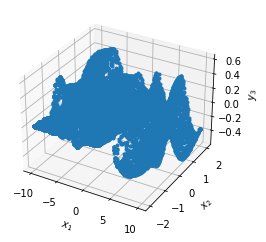

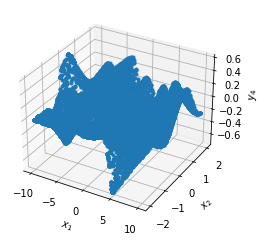

In [48]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-09,
    maxiter=15000,
    maxfun=8000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

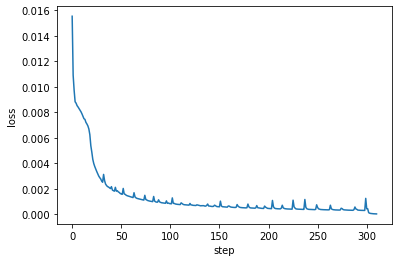

In [49]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

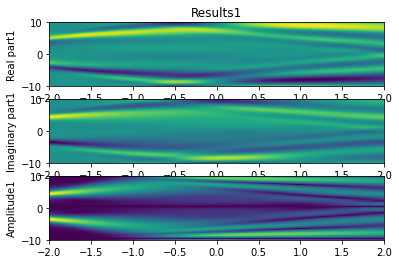

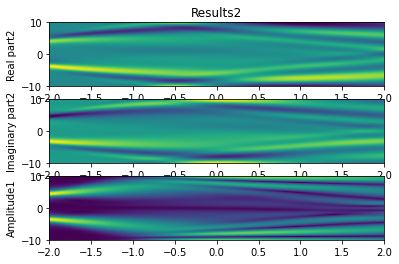

In [50]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()

[    1533     1347     1177 ... 11617541 10100140  8665234]


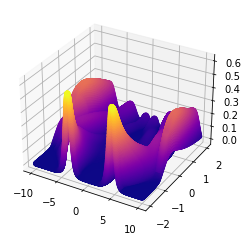

In [51]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:],cmap='plasma')

[     2234      4081      6447 ... 716297600 689443200 661689920]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


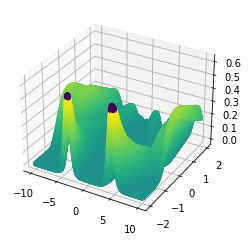

In [52]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [53]:
print(c)

2.666397e-10


In [54]:
b=1
c=2
a=complex(b,c)
print(a)

(1+2j)


In [55]:
z=-1j
print(z)

(-0-1j)


In [56]:
print(z.imag)

-1.0
